In [76]:
# !unzip /Faces.zip

In [77]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from utils import create_images_list


# Preparación de los datos

In [78]:
facesPath = 'Faces' # use '/content/Faces' on colab
faces = create_images_list([facesPath])
faces.shape


  0%|          | 0/12833 [00:00<?, ?it/s]

100%|██████████| 12833/12833 [00:02<00:00, 4856.86it/s]


(12833, 64, 64)

In [79]:
from constants import (BACKGROUND_PATH)
backgrounds = create_images_list([BACKGROUND_PATH])
backgrounds.shape


100%|██████████| 12800/12800 [00:03<00:00, 3695.16it/s]


(12800, 64, 64)

In [80]:
images = list(faces) + list(backgrounds)

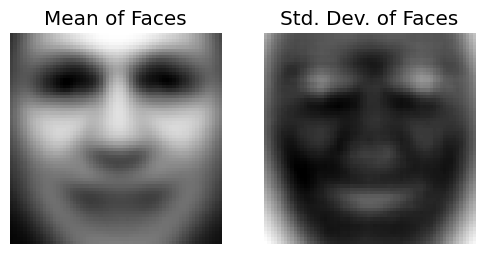

In [81]:
# Calculamos la imagen promedio y la desviación estándar para cada dígito
mean_images = np.mean(images, axis=0)
std_images = np.std(images, axis=0)

# Visualizamos las imágenes promedio y las desviaciones estándar
fig, axs = plt.subplots(1, 2, figsize=(6, 6))

axs[0].imshow(mean_images, cmap='gray')
axs[0].set_title(f"Mean of Faces")
axs[0].axis('off')

axs[1].imshow(std_images, cmap='gray')
axs[1].set_title(f"Std. Dev. of Faces")
axs[1].axis('off')

plt.show()

In [82]:
from pca_helper import prepare_data
X_train_pca, X_test, y_train, y_test, scaler, pca = prepare_data(faces, backgrounds, test_size=0.3, random_state=42)

# print shape of X_train_pca, X_test, y_train, y_test, scaler, pca
print(f"X_train_pca shape: {X_train_pca.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"scaler shape: {scaler}")
print(f"pca shape: {pca}")

Construyendo X: 25633it [00:14, 1826.85it/s]


X shape: (25633, 2916)
X_train_pca shape: (17943, 500)
X_test shape: (7690, 2916)
y_train shape: (17943,)
y_test shape: (7690,)
scaler shape: StandardScaler()
pca shape: PCA(n_components=500)


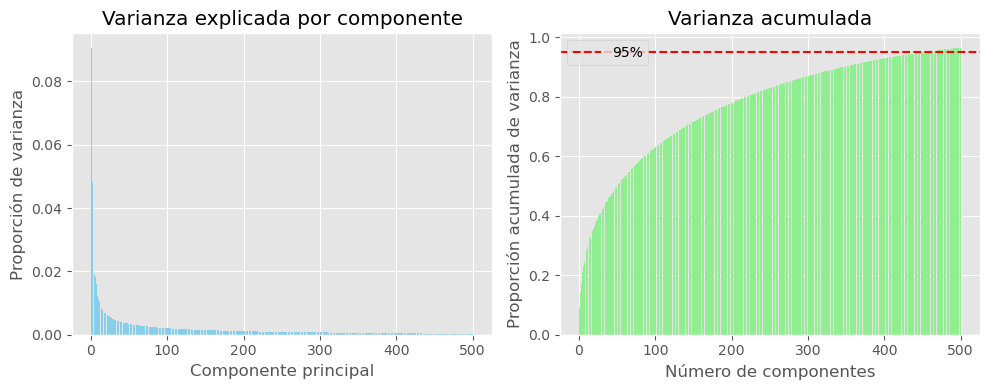

In [83]:
# Obtener varianzas
var_explicada = pca.explained_variance_ratio_
var_acumulada = np.cumsum(var_explicada)

# Gráfico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Varianza explicada
ax1.bar(range(1, len(var_explicada)+1), var_explicada, color='skyblue')
ax1.set_title('Varianza explicada por componente')
ax1.set_xlabel('Componente principal')
ax1.set_ylabel('Proporción de varianza')
ax1.grid(True)

# Varianza acumulada
ax2.bar(range(1, len(var_acumulada)+1), var_acumulada, color='lightgreen')
ax2.axhline(y=0.95, color='r', linestyle='--', label='95%')
ax2.set_title('Varianza acumulada')
ax2.set_xlabel('Número de componentes')
ax2.set_ylabel('Proporción acumulada de varianza')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

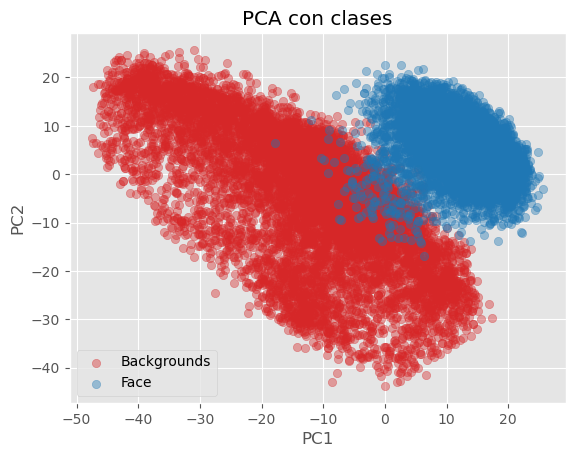

In [84]:
# Graficar con colores y leyenda
colors = ['tab:red', 'tab:blue']
labels = ['Backgrounds', 'Face']

for class_value in [0, 1]:
    plt.scatter(
        X_train_pca[y_train == class_value, 0],
        X_train_pca[y_train == class_value, 1],
        c=colors[class_value],
        label=labels[class_value],
        alpha=0.4
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA con clases')
plt.legend()
plt.grid(True)
plt.show()

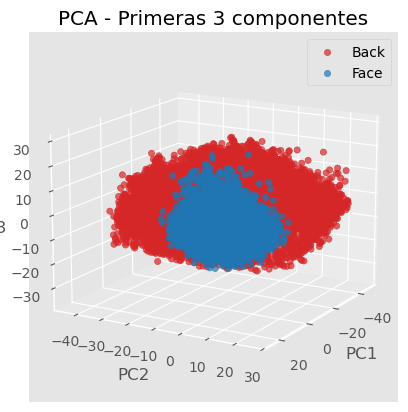

In [85]:
# Plot 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['tab:red', 'tab:blue']
labels = ['Back', 'Face']

for class_value in [0, 1]:
    ax.scatter(
        X_train_pca[y_train == class_value, 0],
        X_train_pca[y_train == class_value, 1],
        X_train_pca[y_train == class_value, 2],
        c=colors[class_value],
        label=labels[class_value],
        alpha=0.7
    )

ax.view_init(elev=15, azim=30)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA - Primeras 3 componentes')
ax.legend()
plt.show()


In [86]:
# Clasificador
model = GaussianNB()

model.fit(X_train_pca, y_train)

y_train_pred = model.predict(X_train_pca)
print(classification_report(y_train, y_train_pred))

# Estandarizar y transformar datos de test
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = model.predict(X_test_pca)

print(f"y_test shape: {y_test.shape}")
print(f"y_test_pred shape: {y_test_pred.shape}")
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96      8990
         1.0       0.97      0.94      0.95      8953

    accuracy                           0.96     17943
   macro avg       0.96      0.96      0.96     17943
weighted avg       0.96      0.96      0.96     17943

y_test shape: (7690,)
y_test_pred shape: (7690,)
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96      3810
         1.0       0.98      0.93      0.95      3880

    accuracy                           0.95      7690
   macro avg       0.96      0.95      0.95      7690
weighted avg       0.96      0.95      0.95      7690



In [87]:
from sklearn.svm import SVC

model = SVC(kernel='rbf', probability=True)
model.fit(X_train_pca, y_train)


y_train_pred = model.predict(X_train_pca)
print(classification_report(y_train, y_train_pred))

# Estandarizar y transformar datos de test
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = model.predict(X_test_pca)

print(f"y_test shape: {y_test.shape}")
print(f"y_test_pred shape: {y_test_pred.shape}")
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8990
         1.0       1.00      1.00      1.00      8953

    accuracy                           1.00     17943
   macro avg       1.00      1.00      1.00     17943
weighted avg       1.00      1.00      1.00     17943

y_test shape: (7690,)
y_test_pred shape: (7690,)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3810
         1.0       1.00      1.00      1.00      3880

    accuracy                           1.00      7690
   macro avg       1.00      1.00      1.00      7690
weighted avg       1.00      1.00      1.00      7690



In [88]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_pca, y_train)

y_train_pred = model.predict(X_train_pca)
print(classification_report(y_train, y_train_pred))

# Estandarizar y transformar datos de test
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = model.predict(X_test_pca)

print(f"y_test shape: {y_test.shape}")
print(f"y_test_pred shape: {y_test_pred.shape}")
print(classification_report(y_test, y_test_pred))




              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8990
         1.0       1.00      1.00      1.00      8953

    accuracy                           1.00     17943
   macro avg       1.00      1.00      1.00     17943
weighted avg       1.00      1.00      1.00     17943

y_test shape: (7690,)
y_test_pred shape: (7690,)
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99      3810
         1.0       1.00      0.97      0.99      3880

    accuracy                           0.99      7690
   macro avg       0.99      0.99      0.99      7690
weighted avg       0.99      0.99      0.99      7690

